In [27]:
# !pip install codeinterpreterapi
# !pip install --upgrade pip

In [28]:
# !pip install -U "langchain<0.0.233"

In [29]:
from dotenv import find_dotenv,load_dotenv
load_dotenv(find_dotenv())

True

In [30]:
top_k = 10000
user_input = \
    '2010年以降のレシピのうち、カロリーが高い順に100個のレシピのカロリーの散布図を書いてください。'

In [64]:
from codeboxapi import CodeBox
codebox = CodeBox()
await codebox.astart()

Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7fea4c2f21d0>
Unclosed connector
connections: ['[(<aiohttp.client_proto.ResponseHandler object at 0x7fea4c2bf0a0>, 1291141.521073457)]']
connector: <aiohttp.connector.TCPConnector object at 0x7fea4c2f2b30>


INFO: Using a LocalBox which is not isolated.
      This is only for testing and development.
      Make sure to put an API-Key in production.



Status(started)

In [32]:
from codeboxapi.schema import CodeBoxOutput  # type: ignore
code = 'print("test")'
output: CodeBoxOutput = await codebox.arun(code)
print(output.content)

test



In [33]:
# !pip install opensearch-py

In [34]:
import os,openai,json
from dotenv import find_dotenv,load_dotenv
load_dotenv(find_dotenv())

openai.api_key = os.environ['OPENAI_API_KEY']
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import HumanMessage

from opensearchpy import OpenSearch

In [35]:
SERVICE_URI = 'localhost:9200'
INDEX_NAME = 'epicurious-recipes'
os_client = OpenSearch(hosts=SERVICE_URI, ssl_enable=True)

In [36]:
mapping_data = os_client.indices.get_mapping(INDEX_NAME)
mappings = mapping_data[INDEX_NAME]['mappings']
print(json.dumps(mappings,indent=2))

{
  "properties": {
    "calories": {
      "type": "float"
    },
    "categories": {
      "type": "text",
      "fields": {
        "keyword": {
          "type": "keyword",
          "ignore_above": 256
        }
      }
    },
    "date": {
      "type": "date"
    },
    "desc": {
      "type": "text",
      "fields": {
        "keyword": {
          "type": "keyword",
          "ignore_above": 256
        }
      }
    },
    "directions": {
      "type": "text",
      "fields": {
        "keyword": {
          "type": "keyword",
          "ignore_above": 256
        }
      }
    },
    "fat": {
      "type": "float"
    },
    "ingredients": {
      "type": "text",
      "fields": {
        "keyword": {
          "type": "keyword",
          "ignore_above": 256
        }
      }
    },
    "protein": {
      "type": "float"
    },
    "rating": {
      "type": "float"
    },
    "sodium": {
      "type": "float"
    },
    "title": {
      "type": "text",
      "fields": {
   

In [37]:
DSL_TEMPLATE = """\
Given an input question, create a syntactically correct Elasticsearch query to run. \
Unless the user specifies in their question a specific number of examples they wish to obtain, \
always limit your query to at most {top_k} results. \
You can order the results by a relevant column to return the most interesting examples in the database.

Unless told to do not query for all the columns from a specific index, \
only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the mapping description. \
Be careful to not query for columns that do not exist. Also, pay attention to which column is in which index. \
Return the query as valid json.

Use the following format:

Question: Question here
ESQuery: Elasticsearch Query formatted as json

Mapping: {mapping}

Question: {input}
ESQuery:
"""

In [38]:
def get_os_dsl(query,k):
    prompt = DSL_TEMPLATE.format(
        top_k=k,
        mapping=json.dumps(mappings,indent=2),
        input=query
    )
    chat = ChatOpenAI()
    messages = [HumanMessage(content=prompt)]
    response = chat(messages)
    # print(response.content)
    return response.content

In [39]:
query = get_os_dsl(user_input,top_k)
# print(query)

In [40]:
print(query)

{
  "size": 100,
  "query": {
    "range": {
      "date": {
        "gte": "2010-01-01"
      }
    }
  },
  "sort": [
    {
      "calories": {
        "order": "desc"
      }
    }
  ],
  "_source": [
    "calories"
  ]
}


In [41]:
result = os_client.search(index=INDEX_NAME,body=json.loads(query))
# print(json.dumps(res,indent=2))

In [72]:
template = '''\
## Input
{user_input}

## Query
{query}

## Instruction
[Input]に対して、OpenSearchで[Query]を入力し検索を行い、検索結果をresultに入力しました。
resultを用いて[Input]に対する回答を得るためのPythonコードを書いてください。
resultは入力済みの状態から開始してください。

'''

In [73]:
prompt = template.format(
    user_input=user_input,query=query
)

In [74]:
print(prompt)

## Input
2010年以降のレシピのうち、カロリーが高い順に100個のレシピのカロリーの散布図を書いてください。

## Query
{
  "size": 100,
  "query": {
    "range": {
      "date": {
        "gte": "2010-01-01"
      }
    }
  },
  "sort": [
    {
      "calories": {
        "order": "desc"
      }
    }
  ],
  "_source": [
    "calories"
  ]
}

## Instruction
[Input]に対して、OpenSearchで[Query]を入力し検索を行い、検索結果をresultに入力しました。
resultを用いて[Input]に対する回答を得るためのPythonコードを書いてください。
resultは入力済みの状態から開始してください。




In [75]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts.chat import HumanMessage
chat = ChatOpenAI(temperature=0.)
messages = [HumanMessage(content=prompt)]
response = chat(messages)

In [76]:
print(response.content)

import matplotlib.pyplot as plt

# カロリーのリストを作成
calories = [hit["_source"]["calories"] for hit in result["hits"]["hits"]]

# カロリーの散布図を作成
plt.scatter(range(1, len(calories)+1), calories)
plt.xlabel("Recipe")
plt.ylabel("Calories")
plt.title("Calories of Recipes (High to Low)")
plt.show()


In [77]:
code = f'result = {json.dumps(result).replace("false","False").replace("null","None")}\n\n'+response.content

In [78]:
print(code[:400])
print()
print(code[-400:])

result = {"took": 49, "timed_out": False, "_shards": {"total": 1, "successful": 1, "skipped": 0, "failed": 0}, "hits": {"total": {"value": 3948, "relation": "eq"}, "max_score": None, "hits": [{"_index": "epicurious-recipes", "_id": "jJeRh4kBirRErZ0HS2YE", "_score": None, "_source": {"calories": 12213.0}, "sort": [12213.0]}, {"_index": "epicurious-recipes", "_id": "XZeRh4kBirRErZ0HTnXs", "_score": 

s-recipes", "_id": "Q5eRh4kBirRErZ0HUoe9", "_score": None, "_source": {"calories": 1591.0}, "sort": [1591.0]}]}}

import matplotlib.pyplot as plt

# カロリーのリストを作成
calories = [hit["_source"]["calories"] for hit in result["hits"]["hits"]]

# カロリーの散布図を作成
plt.scatter(range(1, len(calories)+1), calories)
plt.xlabel("Recipe")
plt.ylabel("Calories")
plt.title("Calories of Recipes (High to Low)")
plt.show()


In [79]:
import uuid, base64, re
from io import BytesIO

In [80]:
import asyncio
from pydantic import BaseModel
class File(BaseModel):
    name: str
    content: bytes

    @classmethod
    def from_path(cls, path: str):
        with open(path, "rb") as f:
            path = path.split("/")[-1]
            return cls(name=path, content=f.read())

    @classmethod
    async def afrom_path(cls, path: str):
        return await asyncio.to_thread(cls.from_path, path)

    @classmethod
    def from_url(cls, url: str):
        import requests  # type: ignore

        r = requests.get(url)
        return cls(name=url.split("/")[-1], content=r.content)

    @classmethod
    async def afrom_url(cls, url: str):
        import aiohttp

        async with aiohttp.ClientSession() as session:
            async with session.get(url) as r:
                return cls(name=url.split("/")[-1], content=await r.read())

    def save(self, path: str):
        with open(path, "wb") as f:
            f.write(self.content)

    async def asave(self, path: str):
        await asyncio.to_thread(self.save, path)

    def show_image(self):
        try:
            from PIL import Image  # type: ignore
        except ImportError:
            print(
                "Please install it with `pip install codeinterpreterapi[image_support]` to display images."
            )
            exit(1)

        from io import BytesIO

        img_io = BytesIO(self.content)
        img = Image.open(img_io)

        # Convert image to RGB if it's not
        if img.mode not in ('RGB', 'L'):  # L is for greyscale images
            img = img.convert('RGB')

        # Display the image
        try:
            # Try to get the IPython shell if available.
            shell = get_ipython().__class__.__name__  # type: ignore

            # If the shell is ZMQInteractiveShell, it means we're in a Jupyter notebook or similar.
            if shell == 'ZMQInteractiveShell':
                from IPython.display import display
                display(img)
            else:
                # We're not in a Jupyter notebook.
                img.show()
        except NameError:
            # We're probably not in an IPython environment, use PIL's show.
            img.show()

    def __str__(self):
        return self.name

    def __repr__(self):
        return f"File(name={self.name})"

In [81]:
output: CodeBoxOutput = await codebox.arun(code)
output_files = []
if output.type == "image/png":
    filename = f"image-{uuid.uuid4()}.png"
    file_buffer = BytesIO(base64.b64decode(output.content))
    file_buffer.name = filename
    output_files.append(File(name=filename, content=file_buffer.read()))
# print(output.content)

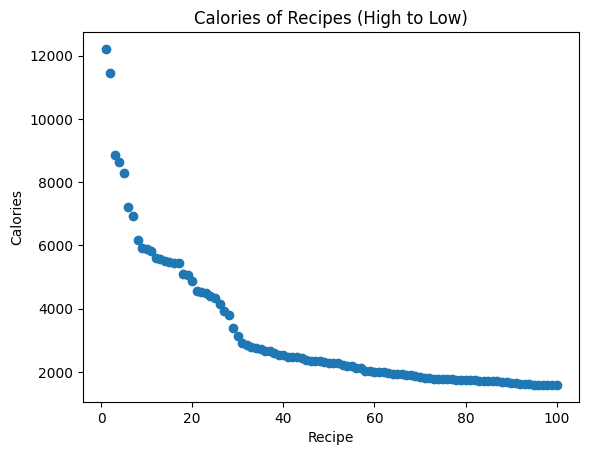

In [82]:
for f in output_files:
    f.show_image()

INFO: Using a LocalBox which is not isolated.
      This is only for testing and development.
      Make sure to put an API-Key in production.

AI:  Here is the plot of a sine wave:

The x-axis represents the values of x ranging from 0 to 2π, and the y-axis represents the corresponding values of sin(x). The plot shows the periodic nature of the sine function, with peaks and valleys occurring at regular intervals.


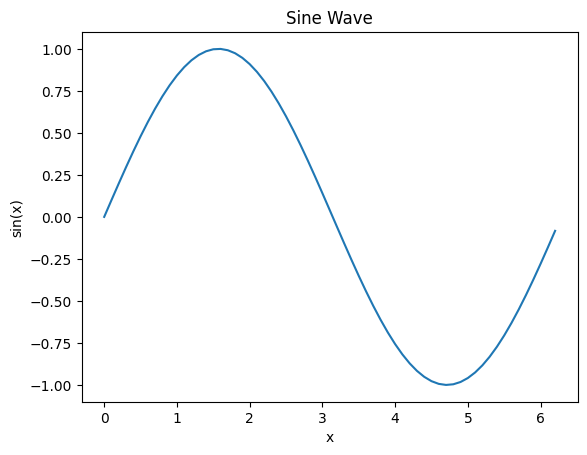

In [87]:
from codeinterpreterapi import CodeInterpreterSession
import langchain; langchain.debug=False
import os
async with CodeInterpreterSession(openai_api_key=os.environ['OPENAI_API_KEY'],model="gpt-3.5-turbo") as session:
    response = await session.generate_response(
        "Plot a sin wave and show it to me."
    )
    print("AI: ", response.content)
    for file in response.files:
        file.show_image()

INFO: Using a LocalBox which is not isolated.
      This is only for testing and development.
      Make sure to put an API-Key in production.

AI:  Here is the plot of Tesla stock price for the year-to-date period in 2023. The y-axis represents the stock price in USD, and the x-axis represents the date.


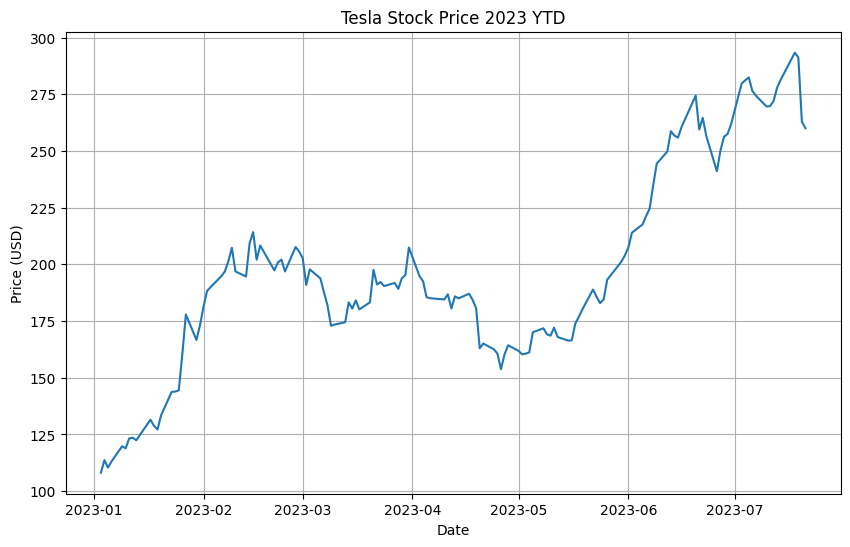

In [86]:
from codeinterpreterapi import CodeInterpreterSession
import langchain; langchain.debug=False
import openai; openai.api_key = os.environ['OPENAI_API_KEY']
session = CodeInterpreterSession(openai_api_key=os.environ['OPENAI_API_KEY'], model="gpt-3.5-turbo-0613")
await session.astart()
output = await session.generate_response(
    "Plot the Tesla stock for 2023 YTD",
    detailed_error = True
)

print("AI: ", output.content)
for file in output.files:
    file.show_image()

await session.astop()

In [88]:
await codebox.astop()

Status(stopped)